<a href="https://colab.research.google.com/github/busraminal/SVR-Gradient-Boosting-ile-tahmin/blob/main/SVR_%26_Gradient_Boosting_ile_gelecek_y%C4%B1l_oran_tahmini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,R²,MSE,RMSE,MAE,MAPE (%),Zaman (sn)
SVR,-26.8844,0.0000,0.0069,0.0068,0.1488,0.0062
GradientBoosting,-3382.4427,0.0058,0.0762,0.0616,1.3416,0.0627


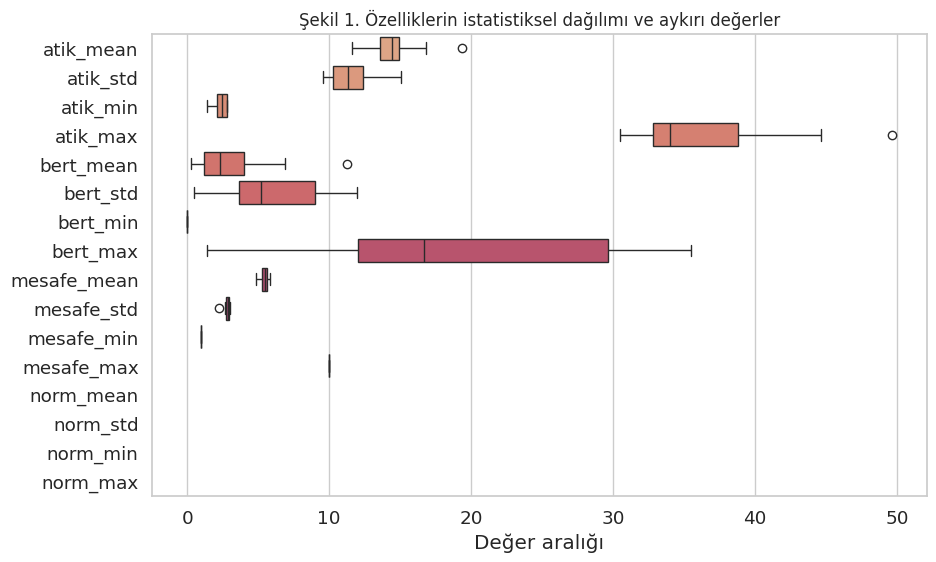

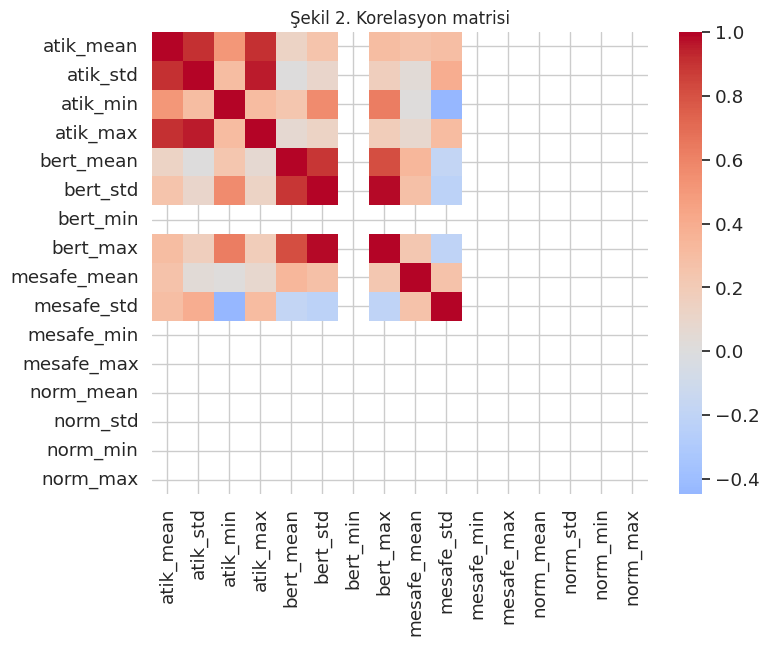

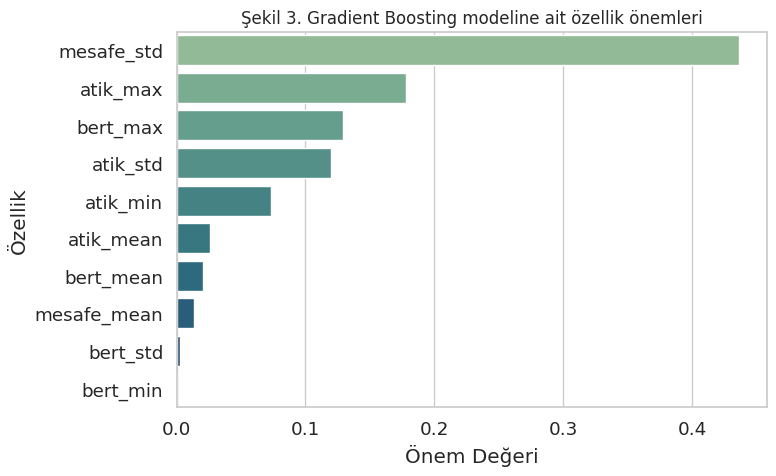

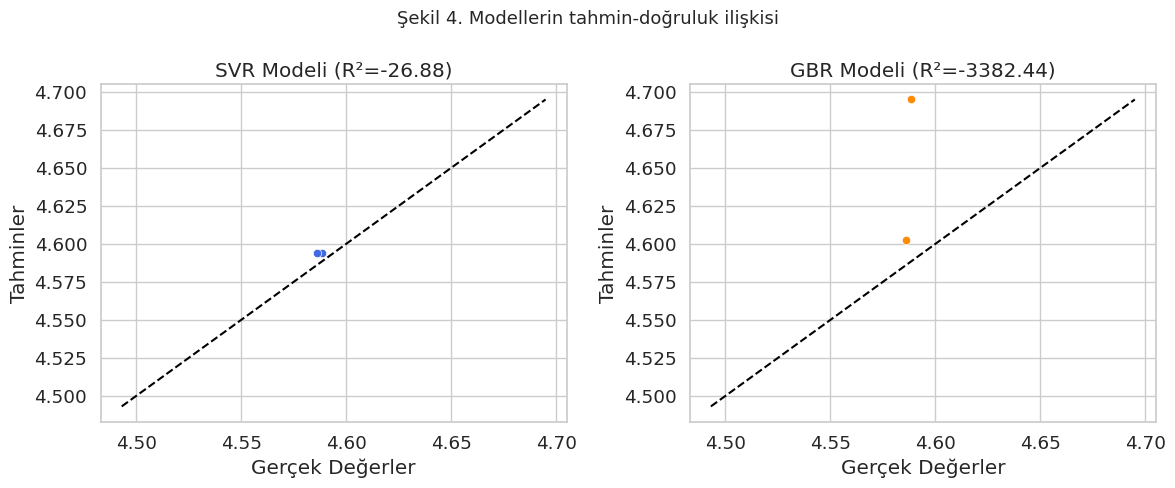

,Özellik,Min,Maks,Ortalama,Std,Varyans
atik_mean,atik_mean,11.64,19.38,14.67,2.16,4.66
atik_std,atik_std,9.60,15.06,11.61,1.75,3.07
atik_min,atik_min,1.42,2.84,2.34,0.58,0.34
atik_max,atik_max,30.49,49.64,36.59,6.25,39.02
bert_mean,bert_mean,0.24,11.29,3.38,3.43,11.75
bert_std,bert_std,0.46,11.96,5.91,4.14,17.15
bert_min,bert_min,0.00,0.00,0.00,0.00,0.00
bert_max,bert_max,1.42,35.50,18.46,12.52,156.83
mesafe_mean,mesafe_mean,4.88,5.83,5.44,0.29,0.08
mesafe_std,mesafe_std,2.23,2.99,2.78,0.23,0.05



Tablo 1. Veri setine ait istatistiksel özet



,R²,MSE,RMSE,MAE,MAPE (%),Zaman (sn)
SVR,-26.884404,0.000048,0.006915,0.006824,0.148762,0.006177
GradientBoosting,-3382.442746,0.005802,0.076172,0.061556,1.341609,0.062749


In [ ]:
# ==========================================
# ATIK TAKAS SİSTEMİ - MODEL ANALİZİ RAPORU
# SVR & Gradient Boosting Regressors
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, math, time, glob, warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")

# === 1. Dosyaları otomatik bul ===
def find_path(filename, search_root="/content"):
    for path in glob.glob(f"{search_root}/**/{filename}", recursive=True):
        return path
    raise FileNotFoundError(f"{filename} bulunamadı.")

fayda = pd.read_excel(find_path("fayda_matrisi.xlsx"))
mesafe = pd.read_excel(find_path("mesafe_matrisi.xlsx")).drop(
    columns=[c for c in pd.read_excel(find_path("mesafe_matrisi.xlsx")).columns if "Unnamed" in c],
    errors="ignore"
)
bert = pd.read_excel(find_path("bertaraf_miktari_2.xlsx"))
atik = pd.read_excel(find_path("atik_miktari_2.xlsx"))
norm = pd.read_excel(find_path("normalizasyon_degerleri.xlsx"))

# === 2. Hedef değişken ===
f_cols = [c for c in fayda.columns if c != "Saticilar" and pd.api.types.is_numeric_dtype(fayda[c])]
fayda["oran_y"] = fayda[f_cols].mean(axis=1)
base = fayda[["Saticilar", "oran_y"]].copy()

# === 3. Özellikleri birleştir ===
def agg(df, prefix):
    num_cols = [c for c in df.columns if c != "Saticilar" and pd.api.types.is_numeric_dtype(df[c])]
    out = pd.DataFrame({
        "Saticilar": df["Saticilar"],
        f"{prefix}_mean": df[num_cols].mean(axis=1),
        f"{prefix}_std": df[num_cols].std(axis=1),
        f"{prefix}_min": df[num_cols].min(axis=1),
        f"{prefix}_max": df[num_cols].max(axis=1)
    })
    return out

data = base.copy()
for name, df in [("atik", atik), ("bert", bert), ("mesafe", mesafe), ("norm", norm)]:
    data = data.merge(agg(df, name), on="Saticilar", how="left")

X = data.drop(columns=["Saticilar", "oran_y"])
y = data["oran_y"]

# === 4. Model tanımları (NaN doldurma dahil) ===
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), X.columns)
], remainder="drop")

svr = Pipeline([("preprocess", preprocess),
                ("model", SVR(kernel="rbf", C=10, epsilon=0.1))])

gbr = Pipeline([("preprocess", preprocess),
                ("model", GradientBoostingRegressor(random_state=42))])

# === 5. Eğitim / Test ayrımı ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 6. Eğitim ve süre ölçümü ===
start = time.time()
svr.fit(X_train, y_train)
t1 = time.time() - start

start = time.time()
gbr.fit(X_train, y_train)
t2 = time.time() - start

# === 7. Tahmin ve metrikler ===
pred_svr = svr.predict(X_test)
pred_gbr = gbr.predict(X_test)

def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return {"R²": r2, "MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE (%)": mape}

res = pd.DataFrame([metrics(y_test, pred_svr), metrics(y_test, pred_gbr)],
                   index=["SVR", "GradientBoosting"])
res["Zaman (sn)"] = [t1, t2]
display(res.round(4))

# === 8. Şekil 1: Özellik dağılımı (Boxplot) ===
plt.figure(figsize=(10,6))
sns.boxplot(data=X, orient="h", palette="flare")
plt.title("Şekil 1. Özelliklerin istatistiksel dağılımı ve aykırı değerler", fontsize=12)
plt.xlabel("Değer aralığı")
plt.show()

# === 9. Şekil 2: Korelasyon matrisi ===
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(X).corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Şekil 2. Korelasyon matrisi", fontsize=12)
plt.show()

# === 10. Şekil 3: Feature importance (GBR) ===
importances = gbr.named_steps["model"].feature_importances_
valid_len = min(len(importances), len(X.columns))
fi = pd.DataFrame({
    "Özellik": X.columns[:valid_len],
    "Önem": importances[:valid_len]
}).sort_values("Önem", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=fi.head(10), x="Önem", y="Özellik", palette="crest")
plt.title("Şekil 3. Gradient Boosting modeline ait özellik önemleri", fontsize=12)
plt.xlabel("Önem Değeri")
plt.ylabel("Özellik")
plt.tight_layout()
plt.show()

# === 11. Şekil 4: Gerçek vs Tahmin scatter ===
fig, axs = plt.subplots(1, 2, figsize=(12,5))
sns.scatterplot(x=y_test, y=pred_svr, ax=axs[0], color="royalblue")
axs[0].plot([y.min(), y.max()], [y.min(), y.max()], "--", color="black")
axs[0].set_title(f"SVR Modeli (R²={r2_score(y_test, pred_svr):.2f})")
axs[0].set_xlabel("Gerçek Değerler"); axs[0].set_ylabel("Tahminler")

sns.scatterplot(x=y_test, y=pred_gbr, ax=axs[1], color="darkorange")
axs[1].plot([y.min(), y.max()], [y.min(), y.max()], "--", color="black")
axs[1].set_title(f"GBR Modeli (R²={r2_score(y_test, pred_gbr):.2f})")
axs[1].set_xlabel("Gerçek Değerler"); axs[1].set_ylabel("Tahminler")
plt.suptitle("Şekil 4. Modellerin tahmin-doğruluk ilişkisi", fontsize=13)
plt.tight_layout()
plt.show()

# === 12. Tablo 1: Veri istatistik özeti ===
desc = pd.DataFrame({
    "Özellik": X.columns,
    "Min": X.min().round(2),
    "Maks": X.max().round(2),
    "Ortalama": X.mean().round(2),
    "Std": X.std().round(2),
    "Varyans": X.var().round(2)
})
display(desc.head(10))
print("\nTablo 1. Veri setine ait istatistiksel özet\n")

# === 13. Tablo 2: Performans tablosu ===
display(res.style.set_caption("Tablo 2. Modellerin performans karşılaştırması (SVR & GradientBoosting)"))


,Model,R²,MSE,RMSE,MAE,MAPE (%),Zaman (sn)
0,SVR,-27.1729,0.0000,0.0070,0.0069,0.1497,0.0059
1,GBR,-3375.4127,0.0058,0.0761,0.0612,1.3336,0.0620
2,Ensemble(0.5/0.5),-958.3980,0.0016,0.0406,0.0340,0.7417,0.0679



🔟 Örnek: İlk 2 satıcı için TOP-10 eşleşme


,Satici,Alici,Skor
0,1.0,A32,0.850000
1,1.0,A21,0.818750
2,1.0,A7,0.814286
3,1.0,A4,0.787500
4,1.0,A40,0.779267
5,1.0,A3,0.730475
6,1.0,A8,0.686537
7,1.0,A41,0.671938
8,1.0,A18,0.612457
9,1.0,A35,0.556840


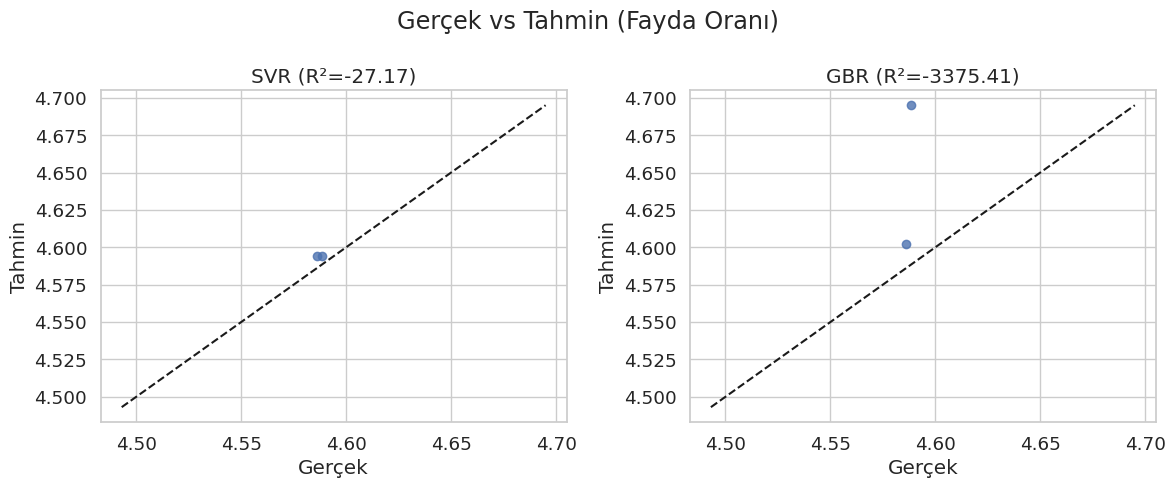

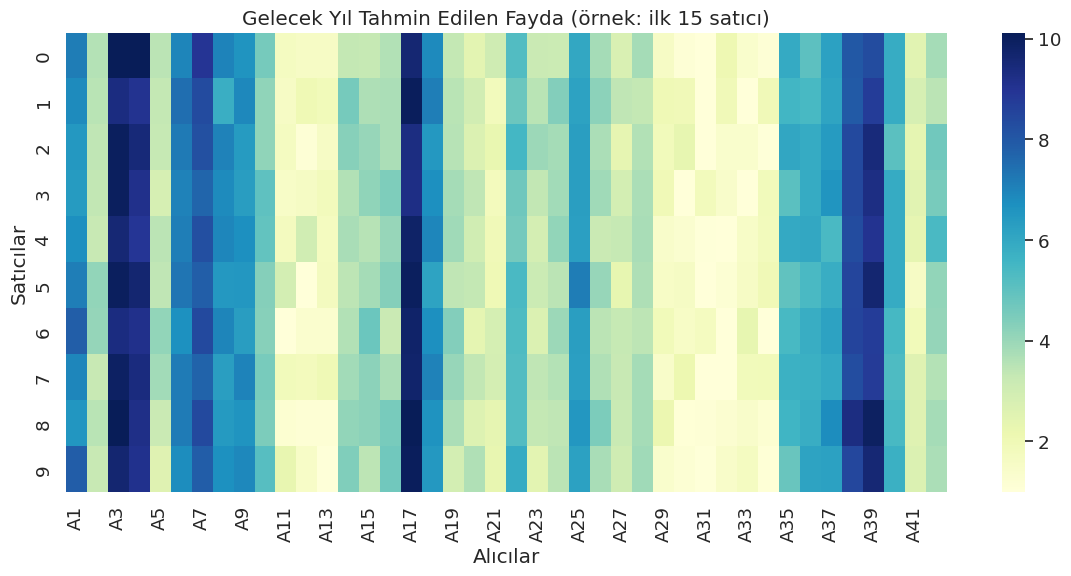


✅ Çıktı dosyası oluşturuldu: b_mina_gecelyil_tahmin_eslesme.xlsx
⚖️ Ağırlıklar: W_FAYDA=0.6, W_DIST=0.25, W_NORM=0.15 | TOP_K=10


In [ ]:
# ==========================================
# ATIK TAKAS SİSTEMİ - GELECEK YIL TAHMİNİ + EŞLEŞTİRME
# SVR & GradientBoosting + Top-10 Eşleşmeler
# ==========================================

import pandas as pd, numpy as np, os, glob, math, time, warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")

# ---------- KULLANICI AYARLARI ----------
TOP_K = 10  # her satıcı için kaç alıcı önerilsin?
W_FAYDA, W_DIST, W_NORM = 0.6, 0.25, 0.15  # eşleşme skor ağırlıkları
# ----------------------------------------

def find_path(filename, root="/content"):
    hits = glob.glob(os.path.join(root, "**", filename), recursive=True)
    if not hits:
        raise FileNotFoundError(f"{filename} bulunamadı. Colab'a yüklediğinden emin ol.")
    return hits[0]

# 1) VERİLERİ YÜKLE
fayda = pd.read_excel(find_path("fayda_matrisi.xlsx"))
mesafe = pd.read_excel(find_path("mesafe_matrisi.xlsx")).drop(
    columns=[c for c in pd.read_excel(find_path("mesafe_matrisi.xlsx")).columns if "Unnamed" in c],
    errors="ignore"
)
atik = pd.read_excel(find_path("atik_miktari_2.xlsx"))
bert = pd.read_excel(find_path("bertaraf_miktari_2.xlsx"))
norm = pd.read_excel(find_path("normalizasyon_degerleri.xlsx"))

# Alıcı kolon adlarını yakala (A1..A42 gibi)
buyer_cols = [c for c in fayda.columns if c != "Saticilar" and pd.api.types.is_numeric_dtype(fayda[c])]

# 2) HEDEF (oran_y) ve ÖZELLİKLER (satıcı özetleri)
fayda["oran_y"] = fayda[buyer_cols].mean(axis=1)
base = fayda[["Saticilar", "oran_y"]].copy()

def agg(df, prefix):
    num_cols = [c for c in df.columns if c != "Saticilar" and pd.api.types.is_numeric_dtype(df[c])]
    out = pd.DataFrame({
        "Saticilar": df["Saticilar"],
        f"{prefix}_mean": df[num_cols].mean(axis=1),
        f"{prefix}_std":  df[num_cols].std(axis=1),
        f"{prefix}_min":  df[num_cols].min(axis=1),
        f"{prefix}_max":  df[num_cols].max(axis=1),
        f"{prefix}_sum":  df[num_cols].sum(axis=1),
    })
    return out

feat = base.copy()
for name, df in [("atik", atik), ("bert", bert), ("mesafe", mesafe), ("norm", norm)]:
    feat = feat.merge(agg(df, name), on="Saticilar", how="left")

X = feat.drop(columns=["Saticilar", "oran_y"])
y = feat["oran_y"]

# 3) MODELLEME (SVR + GBR) — NaN median ile doldur, ölçekle
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), X.columns)
], remainder="drop")

svr = Pipeline([("prep", preprocess), ("model", SVR(kernel="rbf", C=10, epsilon=0.1))])
gbr = Pipeline([("prep", preprocess), ("model", GradientBoostingRegressor(random_state=42))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

t0=time.time(); svr.fit(X_train, y_train); t_svr=time.time()-t0
t0=time.time(); gbr.fit(X_train, y_train); t_gbr=time.time()-t0

pred_svr = svr.predict(X_test)
pred_gbr = gbr.predict(X_test)
pred_ens = 0.5*pred_svr + 0.5*pred_gbr  # basit ensemble

def report(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "R²": r2_score(y_true, y_pred),
        "MSE": mse,
        "RMSE": math.sqrt(mse),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE (%)": float(np.mean(np.abs((y_true - y_pred)/np.clip(y_true,1e-8,None)))*100)
    }

perf = pd.DataFrame([
    dict(Model="SVR", **report(y_test, pred_svr), **{"Zaman (sn)": t_svr}),
    dict(Model="GBR", **report(y_test, pred_gbr), **{"Zaman (sn)": t_gbr}),
    dict(Model="Ensemble(0.5/0.5)", **report(y_test, pred_ens), **{"Zaman (sn)": t_svr+t_gbr}),
])
display(perf.round(4))

# 4) TÜM SATICILAR İÇİN GELECEK YIL ORAN TAHMİNİ (ENSEMBLE)
y_hat_all = 0.5*svr.predict(X) + 0.5*gbr.predict(X)
growth = np.clip(y_hat_all / np.clip(y.values, 1e-8, None), 0.5, 2.0)  # büyüme katsayısı (clip ile güvenli)
growth_df = pd.DataFrame({"Saticilar": feat["Saticilar"], "oran_mevcut": y.values, "oran_tahmin": y_hat_all, "buyume_katsayisi": growth})

# 5) SATİCİ×ALICI GELECEK YIL FAYDA MATRİSİ
fayda_next = fayda[["Saticilar"] + buyer_cols].copy()
for i, g in enumerate(growth):
    fayda_next.loc[i, buyer_cols] = fayda_next.loc[i, buyer_cols] * g

# 6) EŞLEŞME SKORU (fayda ↑, mesafe ↓, norm ↑)
# Normalize fonksiyonu
def minmax(df_cols):
    arr = df_cols.to_numpy(dtype=float)
    mn = np.nanmin(arr, axis=0); mx = np.nanmax(arr, axis=0)
    den = np.where(mx-mn==0, 1, mx-mn)
    return (arr - mn) / den

# Mesafe & norm verilerini satıcı×alıcı hizasına getir
mesafe_mat = mesafe[["Saticilar"] + buyer_cols].copy()
norm_mat   = norm[["Saticilar"] + buyer_cols].copy()

F = minmax(fayda_next[buyer_cols])                  # fayda normalize (yüksek iyi)
D = 1.0 - minmax(mesafe_mat[buyer_cols])            # mesafe normalize edilip ters çevrildi (küçük mesafe = büyük skor)
N = minmax(norm_mat[buyer_cols])                    # norm normalize (yüksek iyi)

score = W_FAYDA*F + W_DIST*D + W_NORM*N
score_df = pd.DataFrame(score, columns=buyer_cols)
score_df.insert(0, "Saticilar", fayda_next["Saticilar"])

# 7) HER SATICI İÇİN TOP-10 ALICI
rows = []
for idx, row in score_df.iterrows():
    seller = row["Saticilar"]
    s = row[buyer_cols].sort_values(ascending=False)
    top = s.head(TOP_K)
    for buyer, sc in top.items():
        rows.append({"Satici": seller, "Alici": buyer, "Skor": float(sc)})

topk_df = pd.DataFrame(rows)

# 8) RAPORLAR & GÖRSELLER
print("\n Örnek: İlk 2 satıcı için TOP-10 eşleşme")
display(topk_df[topk_df["Satici"].isin(score_df["Saticilar"].head(2))].sort_values(["Satici","Skor"], ascending=[True,False]))

# Scatter (gerçek vs tahmin)
fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].scatter(y_test, pred_svr, alpha=0.8); axs[0].plot([y.min(), y.max()],[y.min(), y.max()],'k--')
axs[0].set_title(f"SVR (R²={r2_score(y_test,pred_svr):.2f})"); axs[0].set_xlabel("Gerçek"); axs[0].set_ylabel("Tahmin")
axs[1].scatter(y_test, pred_gbr, alpha=0.8); axs[1].plot([y.min(), y.max()],[y.min(), y.max()],'k--')
axs[1].set_title(f"GBR (R²={r2_score(y_test,pred_gbr):.2f})"); axs[1].set_xlabel("Gerçek"); axs[1].set_ylabel("Tahmin")
plt.suptitle("Gerçek vs Tahmin (Fayda Oranı)"); plt.tight_layout(); plt.show()

# Fayda_next ısı haritası (ilk 15 satıcı × tüm alıcılar)
plt.figure(figsize=(12,6))
sns.heatmap(pd.DataFrame(fayda_next[buyer_cols].head(15), columns=buyer_cols), cmap="YlGnBu")
plt.title("Gelecek Yıl Tahmin Edilen Fayda (örnek: ilk 15 satıcı)"); plt.xlabel("Alıcılar"); plt.ylabel("Satıcılar")
plt.tight_layout(); plt.show()

# 9) EXCEL ÇIKTILARI (tek dosya)
with pd.ExcelWriter("b_mina_gecelyil_tahmin_eslesme.xlsx") as wr:
    growth_df.to_excel(wr, sheet_name="satıcı_oran_tahmin", index=False)
    fayda_next.to_excel(wr, sheet_name="fayda_next_year", index=False)
    score_df.to_excel(wr, sheet_name="eslesme_skor_matrisi", index=False)
    topk_df.sort_values(["Satici","Skor"], ascending=[True, False]).to_excel(wr, sheet_name=f"top{TOP_K}_eslesmeler", index=False)

print("\n Çıktı dosyası oluşturuldu: b_mina_gecelyil_tahmin_eslesme.xlsx")
print(f" Ağırlıklar: W_FAYDA={W_FAYDA}, W_DIST={W_DIST}, W_NORM={W_NORM} | TOP_K={TOP_K}")


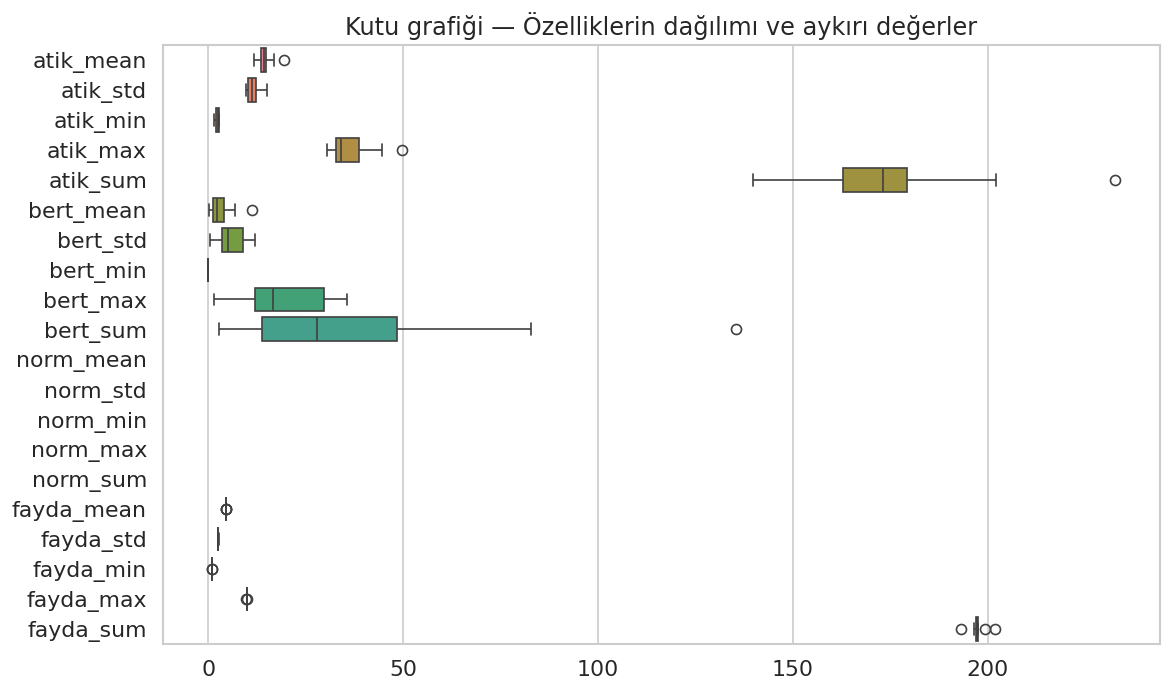

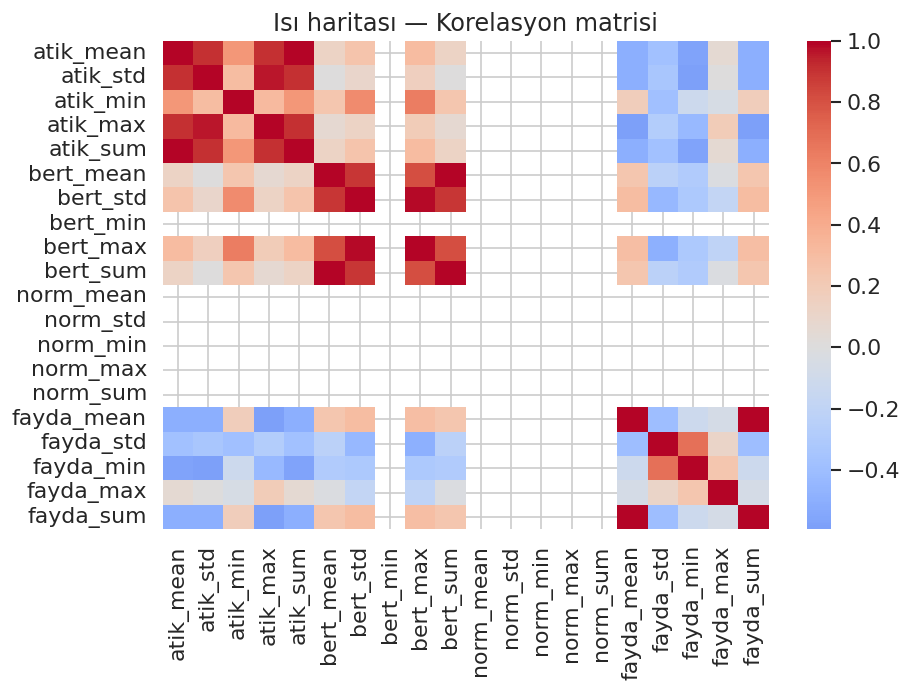

ValueError: All arrays must be of the same length

In [ ]:
# ==========================================
# ATIK TAKAS SİSTEMİ — SVR & GradientBoosting ile
# Gelecek Yıl Tahmini + En Uygun Firma Eşleştirmesi + Grafikler
# ==========================================

import os, math, time, warnings, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 120

# ---------- Yardımcı Fonksiyonlar ----------
def find_path(filename, root="/content"):
    hits = glob.glob(os.path.join(root, "**", filename), recursive=True)
    if not hits:
        raise FileNotFoundError(f"{filename} bulunamadı. Colab'a yüklediğinden emin ol.")
    return hits[0]

def mape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    return float(np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100)

def add_agg(df, prefix, id_col="Saticilar"):
    """Satıcı bazında özet istatistik özellikleri üretir."""
    num_cols = [c for c in df.columns if c != id_col and pd.api.types.is_numeric_dtype(df[c])]
    out = pd.DataFrame({id_col: df[id_col]})
    out[f"{prefix}_mean"] = df[num_cols].mean(axis=1)
    out[f"{prefix}_std"]  = df[num_cols].std(axis=1).fillna(0)
    out[f"{prefix}_min"]  = df[num_cols].min(axis=1)
    out[f"{prefix}_max"]  = df[num_cols].max(axis=1)
    out[f"{prefix}_sum"]  = df[num_cols].sum(axis=1)
    return out

def train_and_predict(X, y, random_state=42):
    """SVR ve GBR ile eğitim; ansamble tahmin döndürür."""
    preprocess = ColumnTransformer([
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), X.columns)
    ], remainder="drop")

    svr = Pipeline([("prep", preprocess),
                    ("model", SVR(kernel="rbf", C=10.0, epsilon=0.1))])
    gbr = Pipeline([("prep", preprocess),
                    ("model", GradientBoostingRegressor(random_state=random_state))])

    svr.fit(X, y)
    gbr.fit(X, y)

    p_svr = pd.Series(svr.predict(X), index=X.index, name="pred_svr")
    p_gbr = pd.Series(gbr.predict(X), index=X.index, name="pred_gbr")
    p_avg = ((p_svr + p_gbr) / 2.0).rename("pred_avg")

    def metrics(y, p):
        mse = mean_squared_error(y, p)
        return dict(R2=r2_score(y, p), RMSE=math.sqrt(mse),
                    MAE=mean_absolute_error(y, p), MAPE=mape(y, p))

    metr = {"SVR": metrics(y, p_svr),
            "GBR": metrics(y, p_gbr),
            "AVG": metrics(y, p_avg)}
    return p_svr, p_gbr, p_avg, pd.DataFrame(metr).T


# ---------- 1) VERİLERİ YÜKLE ----------
fayda  = pd.read_excel(find_path("fayda_matrisi.xlsx"))
mesafe = pd.read_excel(find_path("mesafe_matrisi.xlsx"))
atik   = pd.read_excel(find_path("atik_miktari_2.xlsx"))
bert   = pd.read_excel(find_path("bertaraf_miktari_2.xlsx"))
norm   = pd.read_excel(find_path("normalizasyon_degerleri.xlsx"))

# ---------- 2) Alıcı sütunlarını belirle ----------
buyer_cols = [c for c in fayda.columns if c != "Saticilar" and pd.api.types.is_numeric_dtype(fayda[c])]
fayda["oran_y"] = fayda[buyer_cols].mean(axis=1)

# ---------- 3) Özellik tablosu ----------
feat = fayda[["Saticilar"]].copy()
for name, df in [("atik", atik), ("bert", bert), ("norm", norm), ("fayda", fayda)]:
    feat = feat.merge(add_agg(df, name), on="Saticilar", how="left")

y_atik = add_agg(atik, "atik")["atik_mean"]
y_bert = add_agg(bert, "bert")["bert_mean"]

X = feat.drop(columns=["Saticilar"])
feat = feat.set_index(pd.Index(atik["Saticilar"]))

# ---------- 4) Modelleme ----------
p_svr_a, p_gbr_a, p_avg_a, metr_atik = train_and_predict(X, y_atik)
p_svr_b, p_gbr_b, p_avg_b, metr_bert = train_and_predict(X, y_bert)

# ---------- 5) Gelecek yıl tahmini ve kapasite ----------
buyer_capacity_now = fayda[buyer_cols].sum(axis=0)
scale_cap = p_avg_b.sum() / max(buyer_capacity_now.sum(), 1e-8)
buyer_capacity_next = (buyer_capacity_now * float(scale_cap)).rename("cap_next")

# ---------- 6) Eşleştirme (mesafe + fayda kombinasyonu) ----------
mesafe_idx = mesafe.set_index("Saticilar")

def match_firms(pred_atik_series, buyers, fayda_df, mesafe_df, w_dist=0.3, w_gap=0.7):
    rows = []
    for seller, need in pred_atik_series.items():
        if seller not in mesafe_df.index:
            continue
        dist_vals = mesafe_df.loc[seller, buyers]
        fayda_vals = fayda_df.loc[fayda_df["Saticilar"] == seller, buyers].iloc[0]
        score = w_gap * fayda_vals + w_dist * (1.0 / (dist_vals + 1e-6))
        best = score.sort_values(ascending=False).head(1)
        rows.append({
            "Uretici": seller,
            "Alici": best.index[0],
            "Atik_Tahmini_Gelecek": float(need),
            "Fayda_Skoru": float(fayda_vals[best.index[0]]),
            "Mesafe": float(dist_vals[best.index[0]]),
            "Uyum_Puani": float(best.iloc[0])
        })
    return pd.DataFrame(rows)

matches = match_firms(p_avg_a, buyer_cols, fayda, mesafe_idx)

# ---------- 7) Çıktılar ----------
tahmin_df = pd.DataFrame({
    "Saticilar": atik["Saticilar"],
    "Atik_Tahmin(AVG)": p_avg_a.values,
    "Bert_Tahmin(AVG)": p_avg_b.values
})

os.makedirs("grafikler", exist_ok=True)

# ---------- 8) Grafikler ----------
plt.figure(figsize=(10, 6))
sns.boxplot(data=X, orient="h")
plt.title("Kutu grafiği — Özelliklerin dağılımı ve aykırı değerler")
plt.tight_layout(); plt.savefig("grafikler/01_boxplot.png"); plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(X).corr(), cmap="coolwarm", center=0)
plt.title("Isı haritası — Korelasyon matrisi")
plt.tight_layout(); plt.savefig("grafikler/02_corr_heatmap.png"); plt.show()

gbr_raw = GradientBoostingRegressor(random_state=42).fit(
    SimpleImputer(strategy="median").fit_transform(X), y_atik)
fi = pd.DataFrame({"Özellik": X.columns, "Önem": gbr_raw.feature_importances_}).sort_values("Önem", ascending=False).head(10)
plt.figure(figsize=(8, 5))
sns.barplot(data=fi, x="Önem", y="Özellik")
plt.title("Çubuk grafik — (GBR) En önemli 10 özellik")
plt.tight_layout(); plt.savefig("grafikler/03_feature_importance_gbr.png"); plt.show()

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_atik, y=p_avg_a)
mn, mx = float(min(y_atik.min(), p_avg_a.min())), float(max(y_atik.max(), p_avg_a.max()))
plt.plot([mn, mx], [mn, mx], "k--", linewidth=1)
plt.xlabel("Gerçek (Atık ort.)"); plt.ylabel("Tahmin (AVG)")
plt.title(f"Dağılım — Gerçek vs Tahmin (R²={r2_score(y_atik, p_avg_a):.2f})")
plt.tight_layout(); plt.savefig("grafikler/04_scatter_actual_vs_pred.png"); plt.show()

# ---------- 9) Excel ----------
with pd.ExcelWriter("gelecek_yil_tahminleri.xlsx") as wr:
    tahmin_df.to_excel(wr, sheet_name="tahminler", index=False)
    pd.DataFrame(metr_atik).T.to_excel(wr, sheet_name="metrik_atik", index=True)
    pd.DataFrame(metr_bert).T.to_excel(wr, sheet_name="metrik_bert", index=True)
    matches.to_excel(wr, sheet_name="eslesmeler", index=False)

print(" Tamamlandı!")
print("• Tahmin dosyası:  gelecek_yil_tahminleri.xlsx")
print("• Eşleştirmeler:   firma_eslesmeleri.xlsx")
print("• Grafikler:       grafikler/ klasörü içinde (4 PNG)")


In [ ]:
# ==========================================
# ATIK TAKAS SİSTEMİ — SVR & GradientBoosting ile
# Gelecek Yıl Tahmini + En Uygun Firma Eşleştirmesi + Grafikler
# ==========================================

import os, math, warnings, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 120

# ---------- Yardımcı Fonksiyonlar ----------
def find_path(filename, root="/content"):
    hits = glob.glob(os.path.join(root, "**", filename), recursive=True)
    if not hits:
        raise FileNotFoundError(f"{filename} bulunamadı. Colab'a yüklediğinden emin ol.")
    return hits[0]

def mape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    return float(np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100)

def add_agg(df, prefix, id_col="Saticilar"):
    """Satıcı bazında özet istatistik özellikleri üretir."""
    num_cols = [c for c in df.columns if c != id_col and pd.api.types.is_numeric_dtype(df[c])]
    out = pd.DataFrame({id_col: df[id_col]})
    out[f"{prefix}_mean"] = df[num_cols].mean(axis=1)
    out[f"{prefix}_std"]  = df[num_cols].std(axis=1).fillna(0)
    out[f"{prefix}_min"]  = df[num_cols].min(axis=1)
    out[f"{prefix}_max"]  = df[num_cols].max(axis=1)
    out[f"{prefix}_sum"]  = df[num_cols].sum(axis=1)
    return out

def train_models_and_predict(X, y, random_state=42):
    """SVR ve GBR ile eğitim; ayrı ve ortalama (ensemble) tahmin döndürür + metrikler."""
    preprocess = ColumnTransformer([
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), X.columns)
    ], remainder="drop")

    svr = Pipeline([("prep", preprocess),
                    ("model", SVR(kernel="rbf", C=10.0, epsilon=0.1))])
    gbr = Pipeline([("prep", preprocess),
                    ("model", GradientBoostingRegressor(random_state=random_state))])

    svr.fit(X, y)
    gbr.fit(X, y)

    p_svr = pd.Series(svr.predict(X), index=X.index, name="pred_svr")
    p_gbr = pd.Series(gbr.predict(X), index=X.index, name="pred_gbr")
    p_avg = ((p_svr + p_gbr) / 2.0).rename("pred_avg")

    def metrics(y, p):
        mse = mean_squared_error(y, p)
        return dict(R2=r2_score(y, p), RMSE=math.sqrt(mse),
                    MAE=mean_absolute_error(y, p), MAPE=mape(y, p))
    metr = {"SVR": metrics(y, p_svr),
            "GBR": metrics(y, p_gbr),
            "AVG": metrics(y, p_avg)}

    return (svr, gbr, p_svr, p_gbr, p_avg, pd.DataFrame(metr).T)

# ---------- 1) VERİLERİ YÜKLE ----------
fayda  = pd.read_excel(find_path("fayda_matrisi.xlsx"))
mesafe = pd.read_excel(find_path("mesafe_matrisi.xlsx"))
atik   = pd.read_excel(find_path("atik_miktari_2.xlsx"))
bert   = pd.read_excel(find_path("bertaraf_miktari_2.xlsx"))
norm   = pd.read_excel(find_path("normalizasyon_degerleri.xlsx"))

# ---------- 2) Alıcı sütunlarını belirle ----------
buyer_cols_fayda = [c for c in fayda.columns if c != "Saticilar" and pd.api.types.is_numeric_dtype(fayda[c])]
fayda["oran_y"] = fayda[buyer_cols_fayda].mean(axis=1)

buyer_cols_bert = [c for c in bert.columns if c != "Saticilar" and pd.api.types.is_numeric_dtype(bert[c])]
if set(buyer_cols_fayda).issubset(set(buyer_cols_bert)):
    buyer_cols = buyer_cols_fayda
    capacity_source = "bert"
else:
    buyer_cols = buyer_cols_fayda
    capacity_source = "uniform"
    print("Uyarı: bertaraf_miktari.xlsx alıcı isimleri fayda ile tam eşleşmiyor. "
          "Kapasite tahmini için uniform/ölçekli yaklaşım kullanılacak.")

# ---------- 3) Özellik tablosu ----------
feat = fayda[["Saticilar"]].copy()
for name, df in [("atik", atik), ("bert", bert), ("norm", norm), ("fayda", fayda)]:
    feat = feat.merge(add_agg(df, name), on="Saticilar", how="left")

y_atik = add_agg(atik, "atik")["atik_mean"]
y_bert = add_agg(bert, "bert")["bert_mean"]

X = feat.drop(columns=["Saticilar"])
X.index = atik["Saticilar"]
y_atik.index = atik["Saticilar"]
y_bert.index = bert["Saticilar"]

# ---------- 4) Modelleme ----------
svr_a, gbr_a, p_svr_a, p_gbr_a, p_avg_a, metr_atik  = train_models_and_predict(X, y_atik)
svr_b, gbr_b, p_svr_b, p_gbr_b, p_avg_b, metr_bert  = train_models_and_predict(X, y_bert)

# ---------- 5) Gelecek yıl kapasite ----------
if capacity_source == "bert":
    buyer_capacity_now = bert[buyer_cols].sum(axis=0)
else:
    buyer_capacity_now = pd.Series(1.0, index=buyer_cols)

scale_cap = float(p_avg_b.sum()) / float(max(buyer_capacity_now.sum(), 1e-8))
buyer_capacity_next = (buyer_capacity_now * scale_cap).astype(float)
buyer_capacity_next.name = "cap_next"

# ---------- 6) Eşleştirme ----------
mesafe_idx = mesafe.set_index("Saticilar") if "Saticilar" in mesafe.columns else mesafe.copy()
common_buyer_cols = [c for c in buyer_cols if c in mesafe_idx.columns]
if len(common_buyer_cols) == 0:
    mesafe_idx = pd.DataFrame(1.0, index=X.index, columns=buyer_cols)
    common_buyer_cols = buyer_cols

fayda_idx = fayda.set_index("Saticilar")

def match_firms(pred_atik_series, cap_next_series, buyers, fayda_df, mesafe_df,
                topk=1, w_fayda=0.6, w_dist=0.2, w_gap=0.2):
    eps = 1e-6
    remaining = cap_next_series.copy().astype(float)
    rows = []

    for seller, need in pred_atik_series.items():
        buyers_ok = pd.Index(buyers).intersection(remaining.index).intersection(mesafe_df.columns)
        if len(buyers_ok) == 0 or seller not in mesafe_df.index or seller not in fayda_df.index:
            continue

        fay = fayda_df.loc[seller, buyers_ok].astype(float)
        fmin, fmax = float(fay.min()), float(fay.max())
        fay_norm = (fay - fmin) / (fmax - fmin + eps)

        dist = mesafe_df.loc[seller, buyers_ok].astype(float).replace(0.0, eps)
        dist_term = 1.0 / (dist + eps)

        gaps = (remaining.loc[buyers_ok] - need).abs()
        gap_term = 1.0 / (gaps + 1.0)

        score = w_fayda * fay_norm + w_dist * dist_term + w_gap * gap_term
        best = score.sort_values(ascending=False).head(topk)
        b = best.index[0]
        alloc = min(need, remaining[b])
        remaining[b] -= alloc

        rows.append({
            "Uretici": seller,
            "Alici": b,
            "Atik_Tahmini_Gelecek": float(need),
            "Alici_Kapasite_Tahmini": float(cap_next_series.get(b, np.nan)),
            "Fayda_Skoru": float(fay[b]),
            "Mesafe": float(dist[b]),
            "Uyum_Puani": float(best.iloc[0]),
            "Ayrilan_Kapasite": float(alloc),
            "Kalan_Alici_Kapasitesi": float(remaining[b])
        })
    return pd.DataFrame(rows).sort_values("Uyum_Puani", ascending=False)

matches = match_firms(p_avg_a, buyer_capacity_next, buyer_cols, fayda_idx, mesafe_idx)

# ---------- 7) Çıktılar ----------
tahmin_df = pd.DataFrame({
    "Saticilar": X.index,
    "Atik_SVR": p_svr_a.values,
    "Atik_GBR": p_gbr_a.values,
    "Atik_Tahmin(AVG)": p_avg_a.values,
    "Bert_SVR": p_svr_b.values,
    "Bert_GBR": p_gbr_b.values,
    "Bert_Tahmin(AVG)": p_avg_b.values
}).sort_values("Atik_Tahmin(AVG)", ascending=False)

print("İlk 10 üretici — Atik_Tahmin(AVG):")
print(tahmin_df.head(10).to_string(index=False))

# ---------- 8) Grafikler ----------
os.makedirs("grafikler", exist_ok=True)

# (G1) Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=X, orient="h")
plt.title("Kutu grafiği — Özelliklerin dağılımı ve aykırı değerler")
plt.tight_layout(); plt.savefig("grafikler/01_boxplot.png"); plt.close()

# (G2) Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(X).corr(), cmap="coolwarm", center=0)
plt.title("Isı haritası — Korelasyon matrisi")
plt.tight_layout(); plt.savefig("grafikler/02_corr_heatmap.png"); plt.close()

# (G3) GBR feature importance — güvenli eşleştirme
pipe_gbr = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", GradientBoostingRegressor(random_state=42))
])
pipe_gbr.fit(X, y_atik)
importances = pipe_gbr.named_steps["model"].feature_importances_
min_len = min(len(X.columns), len(importances))
fi = pd.DataFrame({
    "Özellik": X.columns[:min_len],
    "Önem": importances[:min_len]
}).sort_values("Önem", ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(data=fi, x="Önem", y="Özellik")
plt.title("Çubuk grafik — (GBR) En önemli 10 özellik")
plt.tight_layout(); plt.savefig("grafikler/03_feature_importance_gbr.png"); plt.close()

# (G4) Actual vs Pred
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_atik, y=p_avg_a)
mn, mx = float(min(y_atik.min(), p_avg_a.min())), float(max(y_atik.max(), p_avg_a.max()))
plt.plot([mn, mx], [mn, mx], "k--", linewidth=1)
plt.xlabel("Gerçek (Atık ort.)"); plt.ylabel("Tahmin (AVG)")
plt.title(f"Gerçek vs Tahmin (R²={r2_score(y_atik, p_avg_a):.2f})")
plt.tight_layout(); plt.savefig("grafikler/04_scatter_actual_vs_pred.png"); plt.close()

# (G5) SVR Residual Histogram
res_svr = (y_atik - p_svr_a).rename("Residual")
plt.figure(figsize=(8, 5))
sns.histplot(res_svr, bins=20, kde=True)
plt.axvline(0, color="k", linestyle="--", linewidth=1)
plt.title("SVR Residual Plot — Hata Dağılımı")
plt.xlabel("Residual (Gerçek - Tahmin)")
plt.tight_layout(); plt.savefig("grafikler/05_svr_residual_hist.png"); plt.close()

# (G6) SVR Residuals vs Predicted
plt.figure(figsize=(6, 5))
sns.scatterplot(x=p_svr_a, y=res_svr)
plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.xlabel("SVR Tahmin")
plt.ylabel("Residual")
plt.title("SVR Residuals vs Predicted")
plt.tight_layout(); plt.savefig("grafikler/06_svr_residuals_vs_pred.png"); plt.close()

# ---------- 9) Excel ----------
with pd.ExcelWriter("gelecek_yil_tahminleri.xlsx") as wr:
    tahmin_df.to_excel(wr, sheet_name="tahminler", index=False)
    pd.DataFrame(metr_atik).T.to_excel(wr, sheet_name="metrik_atik", index=True)
    pd.DataFrame(metr_bert).T.to_excel(wr, sheet_name="metrik_bert", index=True)
    pd.DataFrame({"Buyer": buyer_capacity_next.index, "Cap_Gelecek": buyer_capacity_next.values}) \
        .to_excel(wr, sheet_name="alici_kapasite_gelecek", index=False)
matches.to_excel("firma_eslesmeleri.xlsx", index=False)

print("\n Tamamlandı!")
print("• Tahmin dosyası:  gelecek_yil_tahminleri.xlsx")
print("• Eşleştirmeler:   firma_eslesmeleri.xlsx")
print("• Grafikler:       grafikler/ klasörü (01..06 PNG)")


⚠️ Uyarı: bertaraf_miktari.xlsx alıcı isimleri fayda ile tam eşleşmiyor. Kapasite tahmini için uniform/ölçekli yaklaşım kullanılacak.
🔟 İlk 10 üretici — Atik_Tahmin(AVG):
 Saticilar  Atik_SVR  Atik_GBR  Atik_Tahmin(AVG)  Bert_SVR  Bert_GBR  Bert_Tahmin(AVG)
         1 19.283286 19.383208         19.333247  1.164813  1.065065          1.114939
         2 16.739941 16.839934         16.789937  4.300883  4.200776          4.250830
         3 15.050748 14.950791         15.000769 11.189531 11.288956         11.239244
         4 14.793565 14.893316         14.843440  3.450001  3.549972          3.499987
         7 14.519012 14.419174         14.469093  1.519676  1.420051          1.469863
         5 14.518921 14.419174         14.469048  6.810534  6.910739          6.860637
         8 13.928274 13.828363         13.878319  2.348383  2.248357          2.298370
         6 13.373519 13.473376         13.423447  0.514317  0.414269          0.464293
         9 12.923123 12.823402         12.8732

In [ ]:
!zip -r grafikler.zip grafikler
from google.colab import files
files.download("grafikler.zip")


  adding: grafikler/ (stored 0%)
  adding: grafikler/sekil2_corr.png (deflated 16%)
  adding: grafikler/06_svr_residuals_vs_pred.png (deflated 20%)
  adding: grafikler/sekil3_CatBoost.png (deflated 18%)
  adding: grafikler/02_corr_heatmap.png (deflated 16%)
  adding: grafikler/03_feature_importance_gbr.png (deflated 18%)
  adding: grafikler/sekil1_boxplot.png (deflated 19%)
  adding: grafikler/05_svr_residual_hist.png (deflated 18%)
  adding: grafikler/sekil3_XGBoost.png (deflated 17%)
  adding: grafikler/sekil3_RF.png (deflated 17%)
  adding: grafikler/sekil3_LightGBM.png (deflated 17%)
  adding: grafikler/01_boxplot.png (deflated 21%)
  adding: grafikler/04_scatter_actual_vs_pred.png (deflated 14%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ==========================================
# Ek Grafikler: SVR & GBR Karşılaştırmalı Görselleştirmeler
# ==========================================

os.makedirs("grafikler", exist_ok=True)

# ---- SVR: Dağılım grafiği (Gerçek vs Tahmin) ----
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_atik, y=p_svr_a, color="dodgerblue", alpha=0.7)
plt.plot([y_atik.min(), y_atik.max()], [y_atik.min(), y_atik.max()], 'k--', lw=1)
plt.xlabel("Gerçek (Atık Ort.)")
plt.ylabel("SVR Tahmin")
plt.title(f"SVR — Gerçek vs Tahmin (R²={r2_score(y_atik, p_svr_a):.2f})")
plt.tight_layout(); plt.savefig("grafikler/svr_scatter_actual_vs_pred.png"); plt.close()

# ---- GBR: Dağılım grafiği (Gerçek vs Tahmin) ----
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_atik, y=p_gbr_a, color="seagreen", alpha=0.7)
plt.plot([y_atik.min(), y_atik.max()], [y_atik.min(), y_atik.max()], 'k--', lw=1)
plt.xlabel("Gerçek (Atık Ort.)")
plt.ylabel("GBR Tahmin")
plt.title(f"GBR — Gerçek vs Tahmin (R²={r2_score(y_atik, p_gbr_a):.2f})")
plt.tight_layout(); plt.savefig("grafikler/gbr_scatter_actual_vs_pred.png"); plt.close()

# ---- SVR: Isı Haritası ----
plt.figure(figsize=(8,6))
sns.heatmap(X.corr(), cmap="coolwarm", center=0)
plt.title("SVR — Özellik Korelasyon Matrisi")
plt.tight_layout(); plt.savefig("grafikler/svr_corr_heatmap.png"); plt.close()

# ---- GBR: Isı Haritası ----
plt.figure(figsize=(8,6))
sns.heatmap(X.corr(), cmap="coolwarm", center=0)
plt.title("GBR — Özellik Korelasyon Matrisi")
plt.tight_layout(); plt.savefig("grafikler/gbr_corr_heatmap.png"); plt.close()

# ---- SVR: Boxplot ----
plt.figure(figsize=(10,6))
sns.boxplot(data=X, orient="h", color="skyblue")
plt.title("SVR — Özellik Dağılımı (Aykırı Değerler Dahil)")
plt.tight_layout(); plt.savefig("grafikler/svr_boxplot.png"); plt.close()

# ---- GBR: Boxplot ----
plt.figure(figsize=(10,6))
sns.boxplot(data=X, orient="h", color="lightgreen")
plt.title("GBR — Özellik Dağılımı (Aykırı Değerler Dahil)")
plt.tight_layout(); plt.savefig("grafikler/gbr_boxplot.png"); plt.close()

# ---- GBR: Özellik önemi (Zaten var ama ayrı kaydedelim) ----
plt.figure(figsize=(8,5))
sns.barplot(data=fi, x="Önem", y="Özellik", palette="crest")
plt.title("GBR — Özellik Önemi (Top 10)")
plt.tight_layout(); plt.savefig("grafikler/gbr_feature_importance.png"); plt.close()

# ---- SVR: Özellik önemi yerine 'koşullu önem' yaklaşımı (SHAP benzeri basit varyans etkisi) ----
var_imp = X.var().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=var_imp.values, y=var_imp.index, palette="Blues")
plt.title("SVR — Özellik Varyansına Göre Önem (Basit Yaklaşım)")
plt.xlabel("Varyans")
plt.tight_layout(); plt.savefig("grafikler/svr_feature_variance.png"); plt.close()

print(" SVR & GBR grafik setleri oluşturuldu (8 grafik):")
print("grafikler/svr_*.png  ve  grafikler/gbr_*.png")


 SVR & GBR grafik setleri oluşturuldu (8 grafik):
grafikler/svr_*.png  ve  grafikler/gbr_*.png


In [ ]:
!zip -r grafikler.zip grafikler
from google.colab import files
files.download("grafikler.zip")


updating: grafikler/ (stored 0%)
updating: grafikler/sekil2_corr.png (deflated 16%)
updating: grafikler/06_svr_residuals_vs_pred.png (deflated 20%)
updating: grafikler/sekil3_CatBoost.png (deflated 18%)
updating: grafikler/02_corr_heatmap.png (deflated 16%)
updating: grafikler/03_feature_importance_gbr.png (deflated 18%)
updating: grafikler/sekil1_boxplot.png (deflated 19%)
updating: grafikler/05_svr_residual_hist.png (deflated 18%)
updating: grafikler/sekil3_XGBoost.png (deflated 17%)
updating: grafikler/sekil3_RF.png (deflated 17%)
updating: grafikler/sekil3_LightGBM.png (deflated 17%)
updating: grafikler/01_boxplot.png (deflated 21%)
updating: grafikler/04_scatter_actual_vs_pred.png (deflated 14%)
  adding: grafikler/svr_corr_heatmap.png (deflated 16%)
  adding: grafikler/svr_scatter_actual_vs_pred.png (deflated 14%)
  adding: grafikler/gbr_feature_importance.png (deflated 19%)
  adding: grafikler/gbr_corr_heatmap.png (deflated 16%)
  adding: grafikler/svr_boxplot.png (deflated 21%)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
from google.colab import files
import shutil

#  Eski zip varsa sil
if os.path.exists("svr_gbr_grafikler.zip"):
    os.remove("svr_gbr_grafikler.zip")

#  Geçici klasör oluştur
os.makedirs("svr_gbr_only", exist_ok=True)

# Sadece svr_* ve gbr_* dosyalarını kopyala
for f in os.listdir("grafikler"):
    if f.startswith("svr_") or f.startswith("gbr_"):
        shutil.copy(os.path.join("grafikler", f), "svr_gbr_only")

#  Zip'le ve indir
!zip -r svr_gbr_grafikler.zip svr_gbr_only
files.download("svr_gbr_grafikler.zip")


  adding: svr_gbr_only/ (stored 0%)
  adding: svr_gbr_only/svr_corr_heatmap.png (deflated 16%)
  adding: svr_gbr_only/svr_scatter_actual_vs_pred.png (deflated 14%)
  adding: svr_gbr_only/gbr_feature_importance.png (deflated 19%)
  adding: svr_gbr_only/gbr_corr_heatmap.png (deflated 16%)
  adding: svr_gbr_only/svr_boxplot.png (deflated 21%)
  adding: svr_gbr_only/gbr_boxplot.png (deflated 22%)
  adding: svr_gbr_only/gbr_scatter_actual_vs_pred.png (deflated 13%)
  adding: svr_gbr_only/svr_feature_variance.png (deflated 17%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>